# in this notebook we will run some exepriements to figure out what the benchmark design should be.

## Experiment 1: what context to include
We have filtered the dataset into documents that work with wgpu (at least naga), are permissively licenses, and extract functions that contain both a comment directly before as well as a docstring directly at the top of the function body.
we compare the four scenarios:
- comment + header
- comment + header + docstring (both)
- header + docstring
- header (none)
it's 4x150 generations. We will use deepseek-coder (1.3b or 6.7b) as that showed promising signs before.

This notebook will just run generations - the postprocessing might be done externally (like here? https://github.com/Vipitis/bigcode-evaluation-harness/tree/shadereval)
or we throw something together tomorrow.

In [37]:
!pip install datasets

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, StopStringCriteria
from accelerate import Accelerator
from datasets import load_dataset
from torch import bfloat16
import json

from tqdm.auto import tqdm

accelerator = Accelerator()
device = accelerator.device
print(device)

experiment_ds = load_dataset("Vipitis/Shadereval-experiments-dev")# , download_mode="force_redownload")
experiment_ds = experiment_ds["test"] if "test" in experiment_ds else experiment_ds #unpack if DatasetDict?
# model_id = "deepseek-ai/deepseek-coder-6.7b-base"
# model_id = "deepseek-ai/deepseek-coder-1.3b-base"
model_id = "ibm-granite/granite-3b-code-base" #IBM model??
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=bfloat16, low_cpu_mem_usage=True).to(device) # this option works on free colab!
tokenizer = AutoTokenizer.from_pretrained(model_id)
stop_words = ["\nfloat", "\nvec", "\nint", "\nmat"] # should cover the really common cases to speed things up.
stop_words = None

pipe = pipeline("text-generation", model=model, tokenizer=model_id, do_sample=False, stop_strings=stop_words, return_full_text=False, max_new_tokens=512, num_return_sequences=1, torch_dtype='bfloat16', device=device)

OSError: [WinError 1114] Eine DLL-Initialisierungsroutine ist fehlgeschlagen. Error loading "c:\Users\Jan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\lib\backend_with_compiler.dll" or one of its dependencies.

In [ ]:
# the exp2 generation code snippet (should be batchable on larger GPUs.)
from transformers.pipelines.pt_utils import KeyDataset
import json

gens = []
for out in tqdm(pipe(KeyDataset(experiment_ds, "model_inp"), tokenizer=tokenizer, max_new_tokens=512, num_return_sequences=1, batch_size = 8), total=len(experiment_ds)):
    gens.append(out[0]["generated_text"]) #check if the access here is correct before running it.
with open(f"exp2_v03_{len(experiment_ds)}_{model_id.split('/')[-1]}.json", "w", encoding="utf-8") as outfile:
    json.dump({"generations":gens}, outfile)

In [ ]:
# alternative variant where we use the pipeline as an iterator
from transformers.pipelines.pt_utils import KeyDataset
import json

gens = {}
for experiment in tqdm(["input_both", "input_comment", "input_docstring", "input_none"]): # need to just run input_none again!
    exp_gens = []
    for out in tqdm(pipe(KeyDataset(experiment_ds, experiment), tokenizer=tokenizer, max_new_tokens=512, num_return_sequences=1)):
        exp_gens.append(out[0]["generated_text"]) #check if the access here is correct before running it.
    with open(f"exp1_v02_{len(experiment_ds)}_{experiment}.json", "w", encoding="utf-8") as outfile:
        json.dump({experiment:exp_gens}, outfile)

with open(f"exp1_gens_{len(experiment_ds)}_.json", "w", encoding="utf-8") as outfile2:
    json.dump(gens, outfile2)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

In [ ]:
# tiny script to assemble intermediate results (not to be rerun) change this after the above fixes have been made.
import json

experiments = ["input_docstring-67b", "input_docstring", "input_both-67b", "input_both", "input_comment-67b", "input_comment", "input_none-67b", "input_none"]
all_runs = {}
for exp in experiments:
    print(exp)
    if exp in ("input_none", "input_both-67b", "input_comment-67b", "input_docstring-67b", "input_none-67b", ): # this is the correct way, but we have them standalone a bit.
        with open(f"exp1_v02_257_{exp}.json", "r", encoding="utf-8") as infile:
            run = json.load(infile)
            all_runs[exp] = run[exp.split("-")[0]]
        continue
    # TODO: just save these files correctly and have a simple loading script.
    with open(f"exp1_v02_257_{exp}.json", "r", encoding="utf-8") as infile:
        run = json.load(infile)
        # print(len(run[exp]))
        all_runs[exp] = [x[0]["generated_text"] for x in run[exp]]

with open(f"exp1_gens_257_13plus67.json", "w", encoding="utf-8") as outfile:
    json.dump(all_runs, outfile)

input_docstring-67b
input_docstring
input_both-67b
input_both
input_comment-67b
input_comment
input_none-67b
input_none


In [ ]:
# load_generations and references
import json
from datasets import load_dataset

experiment_ds = load_dataset("Vipitis/Shadereval-experiments-dev", revision="0.2")# , download_mode="force_redownload")
df = experiment_ds["train"].to_pandas()

# gen_file = "exp1_generations_0-150.json" #old 150 clue
# gen_file = "exp1_gens_257_NO4.json" #new 275 run, but missing input_none run
# gen_file = "exp1_gens_257_13plusTWO.json" # this now includes one run with the larger model... maybe we can do them in parallel?
gen_file = "exp1_gens_257_13plus67.json" # now we include runs fore 1.3 and 6.7 at max_tokens=512 for both!

with open(gen_file, "r", encoding="utf-8") as infile:
    generations = json.load(infile)

# change the order of keys to be "docstrings, both, comment, none"
# generations = {k:generations[k] for k in ["input_docstring-67b", "input_docstring", "input_both-67b", "input_both", "input_comment-67b", "input_comment", "input_none"]}

Generating train split:   0%|          | 0/257 [00:00<?, ? examples/s]

In [10]:
# hack imports
import sys
import os

# Add the parent directory to sys.path
print(sys.path)
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.path.abspath('')), '.')))
print(sys.path)

['d:\\Dokumente\\Uni_OFFLINE\\SoSe2024\\shadertoys-dataset\\experiments', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39', '', 'C:\\Users\\Jan\\AppData\\Roaming\\Python\\Python39\\site-packages', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages', 'd:\\dokumente\\uni_offline\\ws2021_2022\\deeplearning\\project\\bigcode-evaluation-harness', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Jan\\.cache\\huggingface\\modules']
['d:\\Dokumente\\Uni_OFFLINE\\SoSe2024\\shadertoys-dataset\\experiments', 'c:\\U

In [ ]:
# step 1. parse for valid function in (input+generation)
from annotate import parse_functions

for k,v in generations.items():
    df[f"gen_{k}"] = v

NameError: name 'generations' is not defined

In [ ]:
# step 2 clean up and insert the generations into the code as alternatives.
from annotate import parse_functions


def truncate_function(model_inp, model_pred):
    combined = model_inp + model_pred
    functions = parse_functions(combined)
    if functions == []:
        return model_pred + "// incomplete generation! \n"
    # print(f"{len(functions)} functions found: {functions}")
    num_bytes_inp = len(bytes(model_inp, encoding="utf-8"))
    first_function = functions[0]
    end_first_function = first_function[4]
    cleaned_pred = bytes(model_pred, encoding="utf-8")[:end_first_function-num_bytes_inp]
    return cleaned_pred.decode(encoding="utf-8")

def replace_body(row, altered_body, full_col="full_code"):
    start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
    full_code = bytes(row[full_col], encoding="utf-8")
    altered_body_bytes = bytes(altered_body, encoding="utf-8")
    altered_code = full_code[:end_docstring] + altered_body_bytes + full_code[end_function:] #might miss the docstring at times...
    return altered_code.decode(encoding="utf-8")

In [ ]:

for k in generations.keys():
    df[f"gen_{k}_truncated"] = df.apply(lambda x: truncate_function(x[k.split("-")[0]], x[f"gen_{k}"]), axis=1)

for k in generations.keys():
    df[f"{k}_altered"] = df.apply(lambda x: replace_body(x, x[f"gen_{k}_truncated"]), axis=1)

df.head()

,id,comment,header,docstring,body,full_code,func_bytes,has_comment,has_docstring,model_ctx,...,gen_input_none-67b_truncated,gen_input_none_truncated,input_docstring-67b_altered,input_docstring_altered,input_both-67b_altered,input_both_altered,input_comment-67b_altered,input_comment_altered,input_none-67b_altered,input_none_altered
0,4slXD7,"//vec3 i = vec3(.5)+vec3(.5,-.5,-.5);\n//=> fc...",float fcos( float a )\n{,"\n\t//return max(0.0,(cos( a )+.5)/1.5);","\n\treturn pow( cos(a)*.5+.5, 2.0 );\n}","// this looks prettier, but makes it less obvi...","[163, 346, 369, 407, 443]",True,True,"//vec3 i = vec3(.5)+vec3(.5,-.5,-.5);\n//=> fc...",...,\n\tfloat a2 = a * a;\n\tfloat a4 = a2 * a2;\n...,\n\treturn cosf( a );\n},"// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi..."
1,4dSXDd,// This is the big money function that makes t...,float DistanceToObject(vec3 p)\n{,"\n //p += (1.0/p.y)*0.6;\n\n // Rotate, ...","\n if (dot(p, rotDir) > 1.0) p *= rotMat;\n...",/*--------------------------------------------...,"[4341, 4412, 4444, 4534, 6672]",True,True,// This is the big money function that makes t...,...,"\n float d = sdSphere(p, 1.0);\n d = opS...",\n float d = length(p - _position);\n re...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...
2,MlfGR4,// Distance to the voxel\n,float distVoxel (in vec3 p) {,\n\n\t// Update the glow counter,\n\t++glowCounter;\n\n\t// Rounded box\n\tcons...,//////////////////////////////////////////////...,"[1606, 1631, 1660, 1689, 1828]",True,True,// Distance to the voxel\nfloat distVoxel (in ...,...,\n float d = length(p) - 1.0;\n return d...,\n vec3 q = p - voxelPos;\n return lengt...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...
3,MlfGR4,// Distance to the scene and color of the clos...,"vec2 distScene (in vec3 p, out vec3 P) {",\n\n\t// Update the glow counter,\n\t++glowCounter;\n\n\t// Scaling\n\tp *= VOX...,//////////////////////////////////////////////...,"[1830, 1886, 1926, 1955, 3611]",True,True,// Distance to the scene and color of the clos...,...,\n vec3 q = p;\n float d = length(q) - 1...,"\n vec3 P0 = vec3(0.0, 0.0, 0.0);\n vec3...",//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...
4,MlfGR4,// Main function\n,"void mainImage (out vec4 fragColor, in vec2 fr...",\n\n\t// Get the fragment,\n\tvec2 frag = (2.0 * fragCoord.xy - iResolut...,//////////////////////////////////////////////...,"[5899, 5916, 5972, 5994, 9538]",True,True,// Main function\nvoid mainImage (out vec4 fra...,...,\n vec2 uv = fragCoord.xy / iResolution.xy;...,\n vec2 uv = fragCoord.xy / iResolution.xy;...,///////////////////////////////

In [ ]:
# simple lexer via tree-sitter?

# simple lexer?
import tree_sitter

def get_leaves(subtree: tree_sitter.Node, skip_comments: bool=False, rename_identifiers: bool=False) -> list[str]:
    # TODO: add like a wrapper function to give the root node initially...
    tokens = []
    if subtree.child_count == 0:
        if subtree.type == "comment" and skip_comments:
            pass
        elif subtree.type == "identifier" and rename_identifiers:
            # TODO: what about different name spaces - where do we hand this upwards?
            # do we need to like return our mapping to get different placeholders?
            return [f"id"]
        else:
            return [subtree.text]
    else:
        for child in subtree.children:
            tokens.extend(get_leaves(child, skip_comments, rename_identifiers))
    return tokens

# exact_tokens = get_leaves(tree.root_node, skip_comments=False)
# lexical_tokens = get_leaves(tree.root_node, skip_comments=True)
# syntax_tokens = get_leaves(tree.root_node, True, True)
# print(len(exact_tokens))
# print(len(lexical_tokens))
# print(len(syntax_tokens))

# tree.root_node.children[3].children[1].children[0].text
# syntax_tokens

In [ ]:
# removing the three rows  that are causing a crash/hang?

clean_refs = df[~df["id"].isin(("4tGGzd", "tdyyzc"))]["full_code"].tolist()
clean_preds = df[~df["id"].isin(("4tGGzd", "tdyyzc"))]["input_comment_altered"].tolist()


In [ ]:
import evaluate

shadermatch = evaluate.load("../../Thesis/shadermatch") # try loading locally

# evaluate the altered code

# takes two minutes per 254 run?
res = shadermatch.compute(references=clean_refs, predictions=clean_preds)
res


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Expected wgpu-native version (22, 1, 0) but got (22, 1, 0, 0). You may need to run download-wgpu-native.py (in the root of the repo).
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [51]
  │ 
  │ naga::Function [0]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [74]
  │ 
  │ naga::Function [3]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [17]
  │ 
  │ naga::Function [48]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [45]
  │ naga::Expression [46]
  │ naga::Function [13]




{'incomplete_generation': 0.28346456692913385,
 'c0-clone': 0.0,
 'c1-clone': 0.0,
 'c2-clone': 0.007874015748031496,
 'c4-clone': 0.027559055118110236,
 'code_error': 0.22440944881889763,
 'single_color': 0.06299212598425197,
 'variation': 0.3937007874015748}

In [ ]:
print(sum(res.values()))
print(res["incomplete_generation"] + res["code_error"])

1.0
0.5078740157480315


In [ ]:
# takes 64 seconds on laptop, now 40 seconds it seems.
# step 3. run evaluations!

from annotate import run_shader, PARSER
from wgpu_shadertoy import Shadertoy
from PIL import Image
import numpy as np
RESOLUTION = (512, 288) # same as thumbnail, should do for now.

def compare_shaders(reference, prediction):
    if reference == prediction:
        return "c0-clone" #exact match
    if "// incomplete generation! \n" in prediction:
        return "incomplete_generation" # ususally the a loop
    ref_tree = PARSER.parse(bytes(reference, encoding="utf-8"))
    pred_tree = PARSER.parse(bytes(prediction, encoding="utf-8"))
    ref_lex_tokens = get_leaves(ref_tree.root_node, True)
    pred_lex_tokens = get_leaves(pred_tree.root_node, True)
    if ref_lex_tokens == pred_lex_tokens:
        return "c1-clone" #lexical similarity: differences in comments and white spaces only
    ref_syn_tokens = get_leaves(ref_tree.root_node, True, True)
    pred_syn_tokens = get_leaves(pred_tree.root_node, True, True)
    if ref_syn_tokens == pred_syn_tokens:
        return "c2-clone*" #almost syntactic similarity. our identifier replacement isn't perfect yet
    else:
        try:
            pred_shader = Shadertoy(prediction, shader_type="glsl", resolution=RESOLUTION, offscreen=True)
            ref_shader = Shadertoy(reference, shader_type="glsl", resolution=RESOLUTION, offscreen=True)
            pred_frame_data = pred_shader.snapshot(123.456)
            ref_frame_data = ref_shader.snapshot(123.456)
        except Exception as e:
            return "code_error"
        pred_frame = Image.fromarray(np.asarray(pred_frame_data)[..., [2, 1, 0, 3]]).convert('RGB')
        ref_frame = Image.fromarray(np.asarray(ref_frame_data)[..., [2, 1, 0, 3]]).convert('RGB')
        if pred_frame == ref_frame:
            return "c4-clone" #same image essentially? maybe needs a numpy comparison
        elif pred_frame.getcolors(1) is not None:
            return "single_color" #all the same color indicates a "lame variation, silent bug"
        else:
            return "variation" # the remainder.

    # else:
    #     return "other"


def run_comparison(row, k):
    # print(row["id"])
    # hotpatch this to get numbers
    if row["id"] in ("4tGGzd", "tdyyzc"): # we got more now...
        return "skipped"
        # pass #try if they still stall
    ref = row["full_code"]
    pred = row[f"{k}_altered"]
    return compare_shaders(ref, pred)

for k in generations.keys():
    df[f"{k}_comp"] = df.apply(run_comparison, axis=1,k=k)
    print(df[f"{k}_comp"].value_counts())

Expected wgpu-native version (22, 1, 0) but got (0, 0, 0). You may need to run download-wgpu-native.py (in the root of the repo).
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [33]
  │ 
  │ naga::Function [6]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [105]
  │ naga::Expression [106]
  │ naga::Function [1]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [61]
  │ naga::Expression [62]
  │ naga::Function [13]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [33]
  │ naga::Expression [34]
  │ naga::Function [1]


Returning Some(Vector { size: Quad, scalar: Scalar { kind: Float, width: 4 } }) where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expecte

incomplete_generation    125
variation                 70
code_error                34
c4-clone                  13
single_color              10
skipped                    3
c1-clone                   2
Name: input_docstring-67b_comp, dtype: int64


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Bi, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Function [6]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [42]
  │ naga::Expression [32]
  │ naga::Function [4]


Returning Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) where Some(Scalar(Scalar { kind: Float, width: 4 })) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [61]
  │ 
  │ naga::Function [5]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [838]
  │ 
  │ naga::Function [4]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   

incomplete_generation    142
code_error                52
variation                 46
single_color               8
c4-clone                   6
skipped                    3
Name: input_docstring_comp, dtype: int64


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [11]
  │ 
  │ naga::Function [10]


Returning None where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Function [2]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [33]
  │ naga::Expression [34]
  │ naga::Function [1]




incomplete_generation    113
code_error                60
variation                 57
c4-clone                  12
single_color               8
skipped                    3
c1-clone                   3
c2-clone*                  1
Name: input_both-67b_comp, dtype: int64


Returning Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) where Some(Vector { size: Bi, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [64]
  │ 
  │ naga::Function [2]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [60]
  │ 
  │ naga::Function [3]


Returning Some(Vector { size: Quad, scalar: Scalar { kind: Float, width: 4 } }) where Some(Struct { members: [StructMember { name: Some("diffuse"), ty: [1], binding: None, offset: 0 }, StructMember { name: Some("specular"), ty: [1], binding: None, offset: 16 }, StructMember { name: Some("metallic"), ty: [2], binding: None, offset: 28 }, StructMember { name: Some("roughness"), ty: [2], binding: None, offset: 32 }], span: 48 }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
 

incomplete_generation    126
variation                 68
code_error                46
c4-clone                   8
single_color               5
skipped                    3
c1-clone                   1
Name: input_both_comp, dtype: int64


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [90]
  │ 
  │ naga::Function [1]


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [11]
  │ 
  │ naga::Function [10]


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [11]
  │ 
  │ naga::Function [2]


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::E

variation                93
incomplete_generation    77
code_error               56
c4-clone                 13
single_color             13
skipped                   3
c0-clone                  1
c1-clone                  1
Name: input_comment-67b_comp, dtype: int64


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [51]
  │ 
  │ naga::Function [0]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [74]
  │ 
  │ naga::Function [3]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [17]
  │ 
  │ naga::Function [48]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [45]
  │ naga::Expression [46]
  │ naga::Function [13]




variation                94
incomplete_generation    72
code_error               57
single_color             19
c4-clone                 10
skipped                   3
c2-clone*                 2
Name: input_comment_comp, dtype: int64


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [57]
  │ 
  │ naga::Function [1]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [45]
  │ naga::Expression [46]
  │ naga::Function [13]




variation                119
incomplete_generation     56
code_error                56
c4-clone                  13
single_color              10
skipped                    3
Name: input_none-67b_comp, dtype: int64


Returning Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) where Some(Vector { size: Bi, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [15]
  │ 
  │ naga::Function [7]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [34]
  │ naga::Expression [35]
  │ naga::Function [8]


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Bi, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [33]
  │ 
  │ naga::Function [23]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [18]
  │ naga::Expression [19]
  │ naga::Function [2]


Device::create_shad

variation                84
code_error               81
incomplete_generation    60
single_color             19
c4-clone                 10
skipped                   3
Name: input_none_comp, dtype: int64


In [82]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# mapping labels to ids and give givng them an order
label_mapping = {
    'incomplete_generation': 0.0,
    'code_error': 1.0,
    'c0-clone': 2.0,
    'c1-clone': 3.0,
    'c2-clone*': 4.0,
    'c4-clone': 5.0,
    'single_color': 6.0,
    'variation': 7.0,
    'skipped': 8.0,
}

color_range = [
    "#800505", # incomplete_generation
    "#e41a1c", # code_error
    "#f7760c", # c0-clone
    "#f7c10c", # c1-clone
    "#f6f68c", # c2-clone
    "#ebf70c", # c4-clone
    "#1db4de", # single_color
    "#23c21d", # variation
    "#000000", # skipped
]

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', color_range, N=len(color_range))

# Assuming `generations` and `df` are already defined
cols = [f"{k}_comp" for k in generations.keys()]
label_df = df[cols]
label_df.replace(label_mapping, inplace=True)
# label_df = label_df.sort_values(by=cols[5], ascending=False) #sort by comment column
label_arr = label_df.to_numpy()

# Plot the heatmap
plt.figure(figsize=(14, 9))
plt.imshow(label_arr, aspect='auto', interpolation='nearest', cmap=custom_cmap)

# Set x-tick labels
plt.xticks(ticks=np.arange(len(cols)), labels=cols, rotation=45, ha='right')

# Create a color bar with custom ticks and labels
cbar = plt.colorbar()
cbar.set_ticks(list(label_mapping.values()))
cbar.set_ticklabels(list(label_mapping.keys()))
cbar.set_label('Label')

# Set labels and title
plt.xlabel('Experiments')
plt.ylabel('Problems')
plt.title('Heatmap of Experiment Results')

# Show the plot
plt.tight_layout()
# plt.savefig("heatmap.png")
plt.show()

NameError: name 'generations' is not defined

In [ ]:
import pandas as pd
cols = [f"{k}_comp" for k in generations.keys()]
scores = df[cols]
# value counts per column
num_rows = len(scores) - 3 #3 is hard coded number of skips right now.
scores = scores.apply(pd.Series.value_counts, axis=0)
scores = scores/num_rows # get rates instead of counts
scores = scores.fillna(0)
scores = scores.T
scores["error_rate"] = scores["code_error"] + scores["incomplete_generation"]
# scores["clone_rate"] = scores["c0-clone"] + scores["c1-clone"] + scores["c2-clone*"] + scores["c4-clone"]
# scores.sort_values(by="error_rate", ascending=False, inplace=True)
# remove "_comp" from the row names
scores.index = scores.index.str.replace("_comp", "")
# add a miltiindex for model.
scores.index = pd.MultiIndex.from_tuples([(x.split("-")[0], "6.7b") if "-" in x else (x, "1.3b") for x in scores.index], names=["experiment", "model"])
# scores.plot(kind="bar", stacked=True, figsize=(12, 6), colormap=custom_cmap)

# remove skipped column
scores = scores.drop("skipped", axis=1)

scores = scores.T # transpose back

scores.to_latex("scores.tex", float_format="{:.3f}".format)
scores


experiment            input_docstring           input_both            \
model                            6.7b      1.3b       6.7b      1.3b   
c0-clone                     0.000000  0.000000   0.000000  0.000000   
c1-clone                     0.007874  0.000000   0.011811  0.003937   
c2-clone*                    0.000000  0.000000   0.003937  0.000000   
c4-clone                     0.051181  0.023622   0.047244  0.031496   
code_error                   0.133858  0.204724   0.236220  0.181102   
incomplete_generation        0.492126  0.559055   0.444882  0.496063   
single_color                 0.039370  0.031496   0.031496  0.019685   
variation                    0.275591  0.181102   0.224409  0.267717   
error_rate                   0.625984  0.763780   0.681102  0.677165   

experiment            input_comment           input_none            
model                          6.7b      1.3b       6.7b      1.3b  
c0-clone                   0.003937  0.000000   0.000000  0.000000  
c1-clone                   0.003937  0.000000   0.000000  0.000000  
c2-clone*                  0.000000  0.007874   0.000000  0.000000  
c4-clone                   0.051181  0.039370   0.051181  0.039370  
code_error                 0.220472  0.224409   0.220472  0.318898  
incomplete_generation      0.303150  0.283465   0.220472  0.236220  
single_color               0.051181  0.074803   0.039370  0.074803  
variation                  0.366142  0.370079   0.468504  0.330709  
error_rate                 0.523622  0.507874   0.440945  0.555118

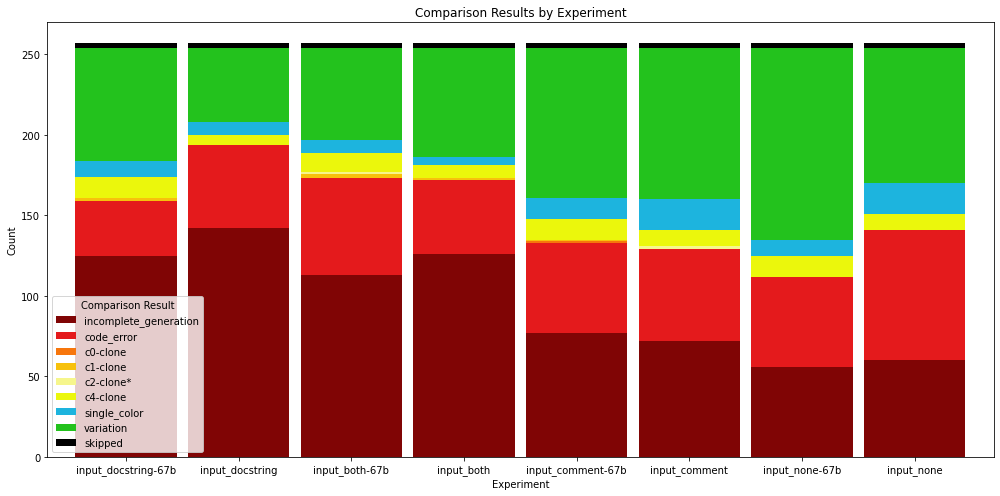

In [ ]:
#all columns are sorted here, gives a better overview.

# via copilot but looks great
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Aggregate the comparison results
# Assuming 'df' is your DataFrame and 'generations.keys()' contains the experiment identifiers
comparison_results = {}
for k in generations.keys():
    comparison_results[k] = df[f"{k}_comp"].value_counts()


# Step 2: Transform the data for plotting
# Convert the dictionary to a DataFrame for easier plotting
comparison_df = pd.DataFrame(comparison_results).fillna(0).T

# use labels and order from above
comparison_df = comparison_df.reindex(columns=list(label_mapping.keys()))
# Step 3: Plot the data using the colors from above
comparison_df.plot(kind='bar', width=0.9, stacked=True, figsize=(14, 7), color=color_range)
plt.title('Comparison Results by Experiment')
plt.xlabel('Experiment')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.legend(title='Comparison Result')
plt.tight_layout()
# plt.savefig("../../Thesis/report/texs/charts/input_experiments.png") # save directly into my thesis folder
plt.show()

In [ ]:
# maybe spot some kind of pattern
# 0 incomplete_generation, 1 code_error
df[label_df["input_comment-67b_comp"] <= 1][["comment", "header"]]


,comment,header
0,"//vec3 i = vec3(.5)+vec3(.5,-.5,-.5);\n//=> fc...",float fcos( float a )\n{
2,// Distance to the voxel\n,float distVoxel (in vec3 p) {
3,// Distance to the scene and color of the clos...,"vec2 distScene (in vec3 p, out vec3 P) {"
4,// Main function\n,"void mainImage (out vec4 fragColor, in vec2 fr..."
5,// color gradient \n// this should be in a 1D ...,vec4 gradient(float x)\n{
...,...,...
242,// 3D Raymarching\n,"vec3 raymarch(vec3 raydir, vec3 rayori){"
245,// -------------------------------------------...,"void mainImage( out vec4 fragColor, in vec2 fr..."
251,//////////////////////////////////////////////...,"void mainImage( out vec4 fragColor, in vec2 fr..."
254,"// License: MIT, author: Inigo Quilez, found: ...","vec3 postProcess(vec3 col, vec2 q) {"


In [ ]:
df["header"].value_counts()

void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    13
vec2 hash22(vec2 p) {                                          5
float noise3D(vec3 p){                                         3
v2 c(v1 U){                                                    3
void mainImage(out vec4 fragColor, in vec2 fragCoord){         3
                                                              ..
float vormod(float f){                                         1
vec3 EnChromaRgb(vec3 c){                                      1
vec4 sdBoxCheap(DAVec3 p,vec3 s){                              1
vec4 sdSuperprim(DAVec3 p, i4 s,vec2 r) {                      1
float cubeSDF(vec3 p) {                                        1
Name: header, Length: 221, dtype: int64

https://shadertoy.com/view/llsSzB
void mainImage( out vec4 fragColor, in vec2 fragCoord )
{


<module 'matplotlib.pyplot' from 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

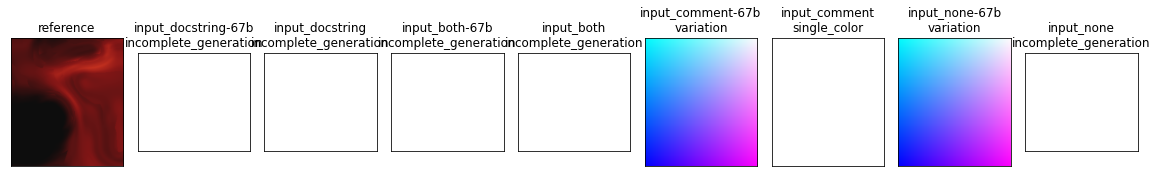

In [ ]:
# parallel comparison of the images

render_res = (212,242)

def plot_comparison(row_idx, time_sample=12.3456):
	print(f"https://shadertoy.com/view/{df.iloc[row_idx]['id']}")
	print(f"{df.iloc[row_idx]['header']}")
	if row_idx == 102 or row_idx == 103:
		print("these should be skipped!!")
		row_idx = 0

	plt.figure(figsize=(16, 5), label=f"row {row_idx}")
	num_plots = len(generations)+1
	plt.subplot(1, num_plots, 1)

	ref = df["full_code"].iloc[row_idx]
	ref_shader = Shadertoy(ref, shader_type="glsl", resolution=render_res, offscreen=True)
	ref_frame_data = ref_shader.snapshot(time_sample)
	ref_frame = Image.fromarray(np.asarray(ref_frame_data)[..., [2, 1, 0, 3]].copy()).convert('RGB')
	plt.imshow(ref_frame)
	plt.title("reference")
	plt.xticks([])
	plt.yticks([])
	for idx, exp in enumerate(generations.keys()):
		# print(idx)
		plt.subplot(1, num_plots, idx+2)
		comp_label = df[f"{exp}_comp"].iloc[row_idx]
		# print(comp_label)
		if comp_label in ("code_error", "skipped", "incomplete_generation", "c0-clone", "c1-clone", "c2-clone*", "c4-clone"):        
			# add a placeholder subplot in these cases
			plt.title(f"{exp}\n{comp_label}")
			plt.imshow(np.ones(shape=render_res + (3,)))
			plt.xticks([])
			plt.yticks([])
			continue
		pred = df[f"{exp}_altered"].iloc[row_idx]
		try:
			pred_shader = Shadertoy(pred, shader_type="glsl", resolution=render_res, offscreen=True)
			pred_frame_data = pred_shader.snapshot(time_sample)
			pred_frame = Image.fromarray(np.asarray(pred_frame_data)[..., [2, 1, 0, 3]].copy()).convert('RGB')
		except Exception as e:
			print(f"Error in {exp}")
			plt.title(f"{exp}\nError")
			continue
		
		# plot the image with the experiment name and _comp label as title
		plt.imshow(pred_frame)
		plt.title(f"{exp}\n{comp_label}")
		plt.xticks([])
		plt.yticks([])
	plt.tight_layout()
		# plt.legend()
	return plt
	plt.show()

plot_comparison(11, 1.3456)

In [ ]:
from ipywidgets import interact
# make the time_sample parameter a slider

interact(plot_comparison, row_idx=(0, 256), time_sample=(0, 20, 0.1))

interactive(children=(IntSlider(value=128, description='row_idx', max=256), FloatSlider(value=12.3456, descrip…

<function __main__.plot_comparison(row_idx, time_sample=12.3456)>

In [12]:
from PIL import ImageChops

tests_row_idx = 64

# compare_field = "input_docstring-67b"
# compare_field = "input_docstring"
compare_field = "input_both-67b"
compare_field = "input_both"
compare_field = "input_comment-67b"
compare_field = "input_comment"
compare_field = "input_none"



# print(df[f"header"].iloc[tests_row_idx])
print(df[compare_field.split("-")[0]].iloc[tests_row_idx],end="")
actual_generation = df[f"gen_{compare_field}"].iloc[tests_row_idx]
print(actual_generation)


ref_shader = Shadertoy(df["full_code"].iloc[tests_row_idx], shader_type="glsl", resolution=render_res, offscreen=True)
pred_shader = Shadertoy(df[f"{compare_field}_altered"].iloc[tests_row_idx], shader_type="glsl", resolution=render_res, offscreen=True)

ref_frame_data = ref_shader.snapshot(12.3456)
pred_frame_data = pred_shader.snapshot(12.3456)

ref_img = Image.fromarray(np.asarray(ref_frame_data)[..., [2, 1, 0, 3]].copy()).convert('RGB')
pred_img = Image.fromarray(np.asarray(pred_frame_data)[..., [2, 1, 0, 3]].copy()).convert('RGB')

# check if they are the same image
ImageChops.difference(ref_img, pred_img)
# # pred_img


# print("-----")
# print(actual_generation)
# print("-----")

# print(truncate_function(df[compare_field.split("-")[0]].iloc[tests_row_idx], actual_generation))
# print("-----")
# print("-----")


# print(replace_body(df.iloc[tests_row_idx], truncate_function(df[compare_field.split("-")[0]].iloc[tests_row_idx], actual_generation)))
# print(df[f"{compare_field}_altered"].iloc[tests_row_idx])
# print(df[f"gen_{compare_field}_truncated"].iloc[tests_row_idx])
# print(df[f"full_code"].iloc[tests_row_idx])

NameError: name 'df' is not defined

# Experiment 2: the real thing? // ANALYSIS

###  we now use the updated shadermatch metric module (https://huggingface.co/spaces/Vipitis/shadermatch), which does up to 10 time/mouse inputs per comaprison before declaring c4 clone.
also labels are now discrete. no overlap per comparisong, but we report the ratio of labels across all 394 comparisons.

In [88]:
import json
from datasets import load_dataset
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

# load referece data
ref_ds = load_dataset("Vipitis/Shadereval-experiments-dev", revision="main")# , download_mode="force_redownload") #might be revision="0.3" eventually.
ref_ds = ref_ds["test"] if "test" in ref_ds else ref_ds #unpack if DatasetDict?
exp_df = ref_ds.to_pandas()

# load the generations

# gen_file = "exp2_v03_394_deepseek-coder-1.3b-base.json"
# gen_file = "exp2_v03_394_deepseek-coder-5.7bmqa-base.json"
# gen_file = "exp2_v03_394_deepseek-coder-6.7b-base.json"
# gen_file = "exp2_v03_394_deepseek-coder-7b-base-v1.5.json"
# gen_file = "exp2_v03_394_CodeQwen1.5-7B.json" 
# gen_file = "exp2_v03_394_CodeQwen1.5-7B-batched.json" #with batch size 16? (and no stop, maybe also eos=pad)
# gen_file = "exp2_v03_394_stable-code-3b.json" #* needs to rerun to save labels!
# gen_file = "exp2_v03_394_granite-3b-code-base.json"
# gen_file = "exp2_v03_394_granite-8b-code-base.json"
# gen_file = "exp2_v03_394_granite-20b-code-base.json"
gen_file = "exp2_v03_394_phi-2.json"
# gen_file = "exp2_v03_394_phi-1_5.json"
# gen_file = "exp2_v03_394_phi-1.json"
# gen_file = "exp2_v03_394_codegemma-2b.json"
# gen_file = "exp2_v03_394_codegemma-7b.json"
# gen_file = "exp2_v03_394_starcoder2-3b.json"
# gen_file = "exp2_v03_394_starcoder2-7b.json"
# gen_file = "exp2_v03_394_starcoder2-15b.json"
# gen_file = "exp2_v03_394_CodeLlama-7b-hf.json"
# gen_file = "exp2_v03_394_CodeLlama-13b-hf.json"
# gen_file = "exp2_v03_394_Meta-Llama-3.1-8B.json"
# gen_file = "exp2_v03_394_Yi-Coder-1.5B.json"
# gen_file = "exp2_v03_394_Yi-Coder-9B.json"
model_id = gen_file.removesuffix(".json").removeprefix("exp2_v03_394_") # hopefully that is right, it's not with phi-1_5...
with open(gen_file, "r", encoding="utf-8") as infile:
    gens = json.load(infile)
exp_df["gens"] = gens["generations"]


# shadermatch = evaluate.load("../../Thesis/shadermatch") # try loading locally
shadermatch = evaluate.load("Vipitis/shadermatch") # load from online module instead.

exp_df.head()

,id,author,date,image_code,license,func_bytes,functions,comment,header,body,model_inp,function_frequency,gens
0,lsfXWH,iq,2014-05-15 00:14:43,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[3256, 3289, 3316, 3316, 3347]","[[1978, 2039, 2083, 2083, 3254], [3256, 3289, ...",// unrolled version of the above\n,float SH_0_0( in vec3 s ) {,vec3 n = s.zxy; return k01; },// unrolled version of the above\nfloat SH_0_0...,3,"// s = (x,y,z)\n float x = s.x;\n fl..."
1,4ssSRl,iq,2014-07-18 08:21:44,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[0, 1196, 1243, 1243, 1363]","[[0, 1196, 1243, 1243, 1363], [1365, 1365, 142...",// The MIT License\n// Copyright © 2014 Inigo ...,"float line( in vec2 a, in vec2 b, in vec2 p )\n{",\n\tvec2 pa = p - a;\n\tvec2 ba = b - a;\n\tfl...,// The MIT License\n// Copyright © 2014 Inigo ...,3,\n return abs( (b.y - a.y) * p.x - (b.x - a...
2,4dBXz3,iq,2014-10-24 08:55:07,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[1272, 1348, 1388, 1388, 1443]","[[1272, 1348, 1388, 1388, 1443], [1445, 1524, ...",// Flip v if in the negative half plane define...,"vec2 flipIfNeg( in vec2 v, in vec2 r )\n{","\n float k = dot(v,r);\n return (k>0.0) ...",// Flip v if in the negative half plane define...,1,\n vec2 w = v - r;\n return w.x * w.x + ...
3,4dBXz3,iq,2014-10-24 08:55:07,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[1445, 1524, 1564, 1564, 1626]","[[1272, 1348, 1388, 1388, 1443], [1445, 1524, ...",// Reflect v if in the negative half plane def...,"vec2 reflIfNeg( in vec2 v, in vec2 r )\n{","\n float k = dot(v,r);\n return (k>0.0) ...",// Reflect v if in the negative half plane def...,1,\n vec2 r2 = r.xy;\n vec2 r3 = r.xyz...
4,4dBXz3,iq,2014-10-24 08:55:07,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[1628, 1704, 1744, 1744, 1834]","[[1272, 1348, 1388, 1388, 1443], [1445, 1524, ...",// Clip v if in the negative half plane define...,"vec2 clipIfNeg( in vec2 v, in vec2 r )\n{","\n float k = dot(v,r);\n return (k>0.0) ...",// Clip v if in the negative half plane define...,1,"\n return v.x < 0.0? vec2(0.0, v.y) : v;\n}..."


In [46]:
# clean up generations and insert them into the code as alterations

def postprocess(row):
    truncated = shadermatch.truncate_generation(model_inp=row["model_inp"], generation=row["gens"])
    altered = shadermatch.replace_body(ref_code=row["image_code"], altered_body=truncated, end_header_byte=row["func_bytes"][2], end_function_byte=row["func_bytes"][4])
    return {"gen_truncated": truncated, "gen_altered": altered}

exp_df[["gen_truncated", "gen_altered"]] = exp_df.progress_apply(postprocess, axis=1, result_type="expand")

# exp_df["gen_truncated"] = exp_df.apply(lambda x: truncate_function(x["model_inp"], x["gens"]), axis=1)
# exp_df["gen_altered"] = exp_df.apply(lambda x: replace_body(x, x["gen_truncated"], "image_code"), axis=1)

  0%|          | 0/394 [00:00<?, ?it/s]

In [2]:
exp_df.head()

,id,author,date,image_code,license,func_bytes,functions,comment,header,body,model_inp,function_frequency,gens
0,lsfXWH,iq,2014-05-15 00:14:43,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[3256, 3289, 3316, 3316, 3347]","[[1978, 2039, 2083, 2083, 3254], [3256, 3289, ...",// unrolled version of the above\n,float SH_0_0( in vec3 s ) {,vec3 n = s.zxy; return k01; },// unrolled version of the above\nfloat SH_0_0...,3,"// s = (x,y,z)\n float x = s.x;\n fl..."
1,4ssSRl,iq,2014-07-18 08:21:44,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[0, 1196, 1243, 1243, 1363]","[[0, 1196, 1243, 1243, 1363], [1365, 1365, 142...",// The MIT License\n// Copyright © 2014 Inigo ...,"float line( in vec2 a, in vec2 b, in vec2 p )\n{",\n\tvec2 pa = p - a;\n\tvec2 ba = b - a;\n\tfl...,// The MIT License\n// Copyright © 2014 Inigo ...,3,\n return abs( (b.y - a.y) * p.x - (b.x - a...
2,4dBXz3,iq,2014-10-24 08:55:07,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[1272, 1348, 1388, 1388, 1443]","[[1272, 1348, 1388, 1388, 1443], [1445, 1524, ...",// Flip v if in the negative half plane define...,"vec2 flipIfNeg( in vec2 v, in vec2 r )\n{","\n float k = dot(v,r);\n return (k>0.0) ...",// Flip v if in the negative half plane define...,1,\n vec2 w = v - r;\n return w.x * w.x + ...
3,4dBXz3,iq,2014-10-24 08:55:07,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[1445, 1524, 1564, 1564, 1626]","[[1272, 1348, 1388, 1388, 1443], [1445, 1524, ...",// Reflect v if in the negative half plane def...,"vec2 reflIfNeg( in vec2 v, in vec2 r )\n{","\n float k = dot(v,r);\n return (k>0.0) ...",// Reflect v if in the negative half plane def...,1,\n vec2 r2 = r.xy;\n vec2 r3 = r.xyz...
4,4dBXz3,iq,2014-10-24 08:55:07,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[1628, 1704, 1744, 1744, 1834]","[[1272, 1348, 1388, 1388, 1443], [1445, 1524, ...",// Clip v if in the negative half plane define...,"vec2 clipIfNeg( in vec2 v, in vec2 r )\n{","\n float k = dot(v,r);\n return (k>0.0) ...",// Clip v if in the negative half plane define...,1,"\n return v.x < 0.0? vec2(0.0, v.y) : v;\n}..."


In [48]:
# might take ~10 minutes? (even 19 minutes?)
result = shadermatch.compute(references=exp_df["image_code"].tolist(), predictions=exp_df["gen_altered"].tolist())
print(len(result["labels"])) # should be 394 for now.
print(sum(result["scores"].values())) # should be 1.0 (or really close)
result["scores"]

  0%|          | 0/394 [00:00<?, ?it/s]

394
1.0


{'incomplete_generation': 0.4213197969543147,
 'c0-clone': 0.0,
 'c1-clone': 0.0025380710659898475,
 'c2-clone': 0.0,
 'c4-clone': 0.005076142131979695,
 'code_error': 0.434010152284264,
 'single_color': 0.012690355329949238,
 'variation': 0.12436548223350254}

In [49]:
# save this to a file
labels_df = pd.read_csv("labels.csv", index_col=0)
# concat or overwrite? (easiest this way.)
labels_df[model_id] = result["labels"]
# save the new column by overwriting the whole file.
labels_df.to_csv(f"labels.csv", mode="w", index=True, header=True, encoding="utf-8")

In [50]:
# save the scores to a file... (can be calculated from the labels I guess)
scores_df = pd.DataFrame(result["scores"], index=[model_id])
scores_df["time"] = pd.Timestamp.now()
scores_df.to_csv(f"results.csv", mode="a", header=False, index=True, index_label="model_id")

### Load the files

In [89]:
import pandas as pd
# load the results
scores_df = pd.read_csv("results.csv", index_col="model_id")
scores_df


,incomplete_generation,c0-clone,c1-clone,c2-clone,c4-clone,code_error,single_color,variation,time
model_id,,,,,,,,,
deepseek-coder-6.7b-base,0.152284,0.035533,0.045685,0.007614,0.083756,0.230964,0.022843,0.421320,2024-08-15 22:04:04.874723
deepseek-coder-1.3b-base,0.177665,0.007614,0.032995,0.005076,0.053299,0.187817,0.032995,0.502538,2024-08-15 22:30:31.420376
CodeQwen1.5-7B,0.167513,0.022843,0.045685,0.020305,0.073604,0.187817,0.020305,0.461929,2024-08-19 19:13:08.872904
stable-code-3b,0.177665,0.010152,0.012690,0.005076,0.065990,0.241117,0.022843,0.464467,2024-08-19 19:30:32.642749
granite-3b-code-base,0.263959,0.007614,0.035533,0.007614,0.060914,0.197970,0.010152,0.416244,2024-08-19 19:49:40.553675
phi-2,0.553299,0.002538,0.005076,0.000000,0.007614,0.195431,0.020305,0.215736,2024-08-19 20:19:16.386315
phi-2,0.553299,0.002538,0.005076,0.000000,0.007614,0.185279,0.020305,0.225888,2024-08-19 23:25:33.328331
granite-3b-code-base,0.263959,0.007614,0.038071,0.007614,0.060914,0.190355,0.010152,0.421320,2024-08-20 00:07:51.354977
stable-code-3b,0.177665,0.010152,0.015228,0.005076,0.065990,0.230964,0.022843,0.472081,2024-08-20 00:28:35.684375


In [90]:
import pandas as pd
#load from file
labels_df = pd.read_csv("labels.csv", index_col=0)
labels_df[model_id].value_counts(normalize=True) # this recovers the scores


phi-2
incomplete_generation    0.434010
code_error               0.314721
variation                0.215736
single_color             0.020305
c4-clone                 0.007614
c1-clone                 0.005076
c0-clone                 0.002538
Name: proportion, dtype: float64

In [91]:
# remove duplicates, only keep the most recent results, use the model_id index to find duplicates
scores_df = scores_df.sort_values(by="time", ascending=False)
scores_df = scores_df[~scores_df.index.duplicated(keep="first")] # uncomment here to only show one result per model, helps to illustrate label shifts.


scores_df["error_rate"] = scores_df["code_error"] + scores_df["incomplete_generation"]
scores_df["clone_rate"] = scores_df["c0-clone"] + scores_df["c1-clone"] + scores_df["c2-clone"] + scores_df["c4-clone"]
# two sorting options for now
scores_df = scores_df.sort_values(by=["error_rate", "incomplete_generation"], ascending=True)
# scores_df = scores_df.sort_values(by="clone_rate", ascending=False) # this sorts by the clone rate (at the top)
scores_df.drop("time", axis=1).to_latex("../../Thesis/report/texs/charts/eval_scores_.tex", float_format="{:.3f}".format) #TODO: improve this or rework the generated file otherwise.
scores_df

,incomplete_generation,c0-clone,c1-clone,c2-clone,c4-clone,code_error,single_color,variation,time,error_rate,clone_rate
model_id,,,,,,,,,,,
CodeLlama-13b-hf,0.101523,0.027919,0.038071,0.005076,0.073604,0.248731,0.022843,0.482234,2024-09-09 00:07:57.280036,0.350254,0.144670
CodeQwen1.5-7B,0.126904,0.022843,0.050761,0.020305,0.073604,0.223350,0.020305,0.461929,2024-08-22 01:24:24.615719,0.350254,0.167513
deepseek-coder-1.3b-base,0.142132,0.010152,0.032995,0.007614,0.053299,0.218274,0.032995,0.502538,2024-08-23 18:38:01.280256,0.360406,0.104061
deepseek-coder-7b-base-v1.5,0.159898,0.030457,0.043147,0.005076,0.078680,0.200508,0.032995,0.449239,2024-09-09 00:30:26.568364,0.360406,0.157360
deepseek-coder-5.7bmqa-base,0.114213,0.025381,0.048223,0.005076,0.076142,0.261421,0.015228,0.454315,2024-09-04 21:44:43.709038,0.375635,0.154822
deepseek-coder-6.7b-base,0.109137,0.035533,0.048223,0.007614,0.083756,0.271574,0.022843,0.421320,2024-08-23 02:55:35.208463,0.380711,0.175127
starcoder2-15b,0.104061,0.027919,0.065990,0.010152,0.083756,0.279188,0.017766,0.411168,2024-09-03 00:08:54.706601,0.383249,0.187817
granite-20b-code-base,0.144670,0.025381,0.045685,0.005076,0.081218,0.248731,0.012690,0.436548,2024-09-02 01:09:08.650138,0.393401,0.157360
Meta-Llama-3.1-8B,0.167513,0.000000,0.043147,0.002538,0.053299,0.236041,0.038071,0.459391,2024-08-23 19:34:05.118840,0.403553,0.098985


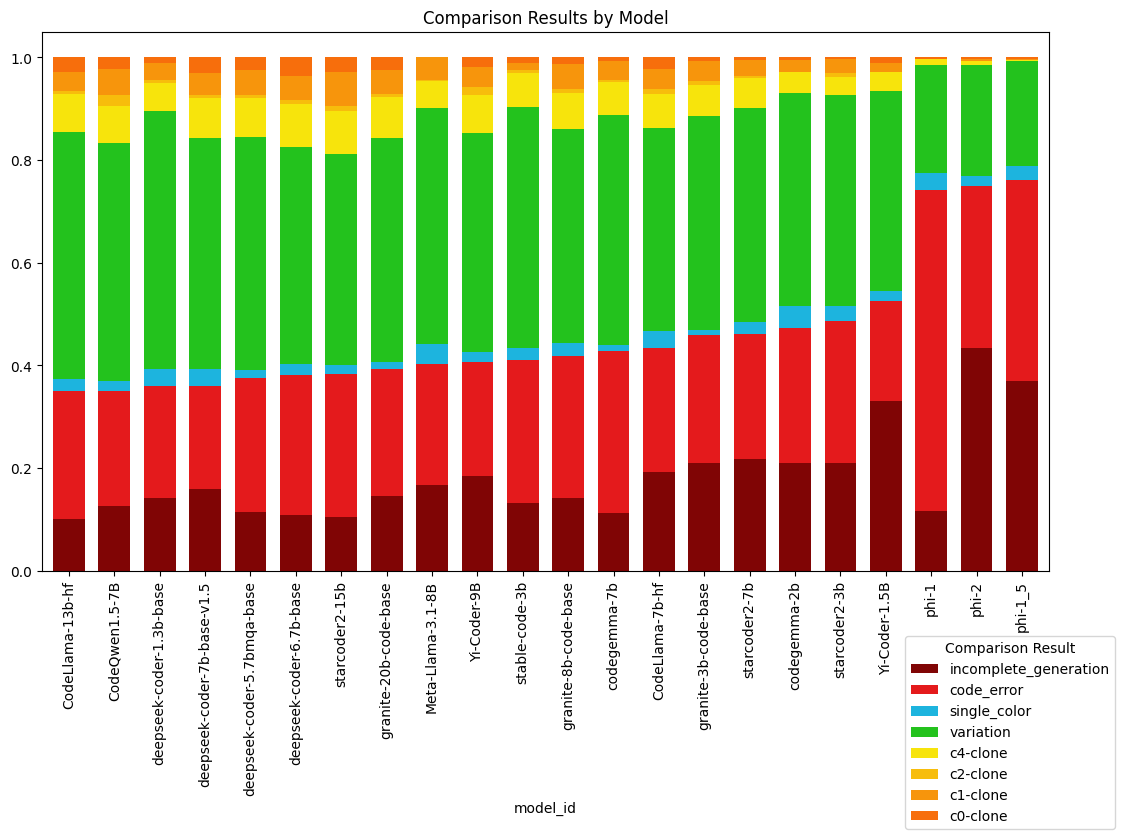

In [92]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# mapping labels to ids and give givng them an order
colors = {
    'incomplete_generation': "#800505",
    'code_error': "#e41a1c",
    'single_color': "#1db4de",
    'variation': "#23c21d",
    # 'samey-variation' : "#e3f70c", # <- just a good color I'd say.
    'c4-clone': "#f7e40c",
    'c2-clone': "#f7bd0c",
    'c1-clone': "#f7950c",
    'c0-clone': "#f76e0c",
    # 'skipped': "#FF1010",
}

# Create the custom colormap
col_map = LinearSegmentedColormap.from_list('col_map', list(colors.values()), N=len(colors))

# reorder the labels to match the colors
plot_df = scores_df.reindex(columns=list(colors.keys())) # this removes the error_rate and clone_rate again?
# plot_df = plot_df[plot_df.index.str.startswith("star")] # only blot some model family

# plot the results
fig, ax = plt.subplots(figsize=(13, 7))
plot_df.plot(kind='bar', width=0.7, stacked=True, colormap=col_map, ax=ax)
ax.set_title('Comparison Results by Model')
# add legend outside the plotting area
ax.legend(loc='center left', bbox_to_anchor=(0.85, -0.3), title='Comparison Result')
# ax.legend()
# plt.tight_layout()
plt.savefig("../../Thesis/report/texs/charts/prelim_results.png", bbox_inches="tight")
plt.show()

In [93]:
# num args by counting commas, is +1 but could have a tailing comma...
(exp_df["header"].str.count(",")+1).value_counts()
# (exp_df["header"].str.count(",")+1).hist(bins=8)

header
1    122
2    104
3     78
4     47
5     32
6      6
7      4
8      1
Name: count, dtype: int64

In [94]:
# calculate solve rates, error rates etc per label

# Function to calculate normalized value counts for a row
def normalized_value_counts(row):
    value_counts = row.value_counts(normalize=True)
    return value_counts

# Apply the function to each row and create a new DataFrame
labels_rates = labels_df.apply(normalized_value_counts, axis=1).fillna(0)

labels_rates["error_rate"] = labels_rates["code_error"] + labels_rates["incomplete_generation"]
labels_rates["clone_rate"] = labels_rates["c0-clone"] + labels_rates["c1-clone"] + labels_rates["c2-clone"] + labels_rates["c4-clone"]
difficulty_order = labels_rates.sort_values(by=["error_rate"] + ["incomplete_generation"] + ["clone_rate"], ascending=True).index # still not happy about how clones look here, I want them grouped near the top...
labels_rates.iloc[difficulty_order]

,c0-clone,c1-clone,c2-clone,c4-clone,code_error,incomplete_generation,single_color,variation,error_rate,clone_rate
29,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000
32,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000
125,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000
260,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000
50,0.0,0.272727,0.0,0.045455,0.000000,0.000000,0.0,0.681818,0.0,0.318182
...,...,...,...,...,...,...,...,...,...,...
27,0.0,0.000000,0.0,0.000000,0.318182,0.681818,0.0,0.000000,1.0,0.000000
151,0.0,0.000000,0.0,0.000000,0.318182,0.681818,0.0,0.000000,1.0,0.000000
53,0.0,0.000000,0.0,0.000000,0.227273,0.772727,0.0,0.000000,1.0,0.000000
390,0.0,0.000000,0.0,0.000000,0.181818,0.818182,0.0,0.000000,1.0,0.000000


C:\Users\Jan\AppData\Local\Temp\ipykernel_12724\4002992149.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_df = labels_df.replace({k:i for i,(k,v) in enumerate(colors.items())})
C:\Users\Jan\AppData\Local\Temp\ipykernel_12724\4002992149.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(list(colors.keys()))


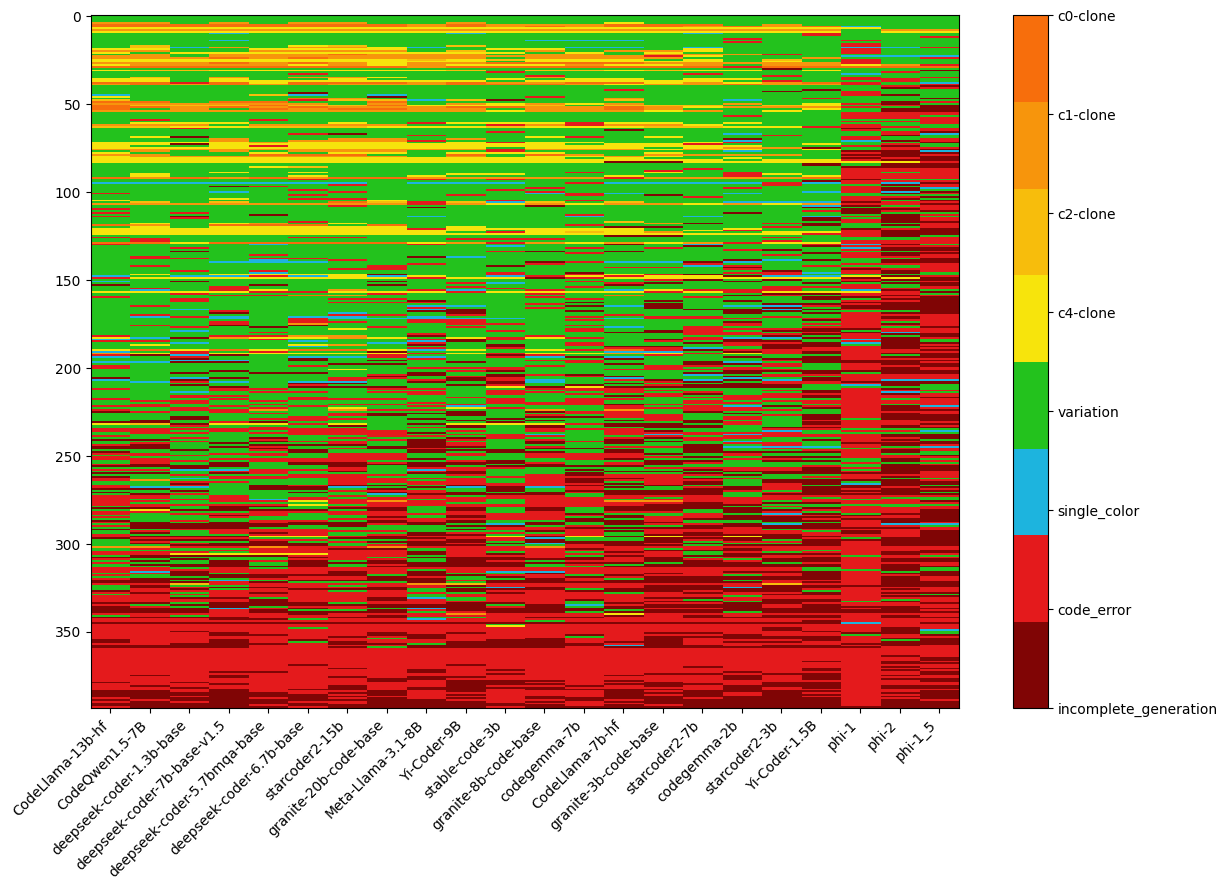

In [95]:
import numpy as np
import matplotlib.pyplot as plt
# from ipywidgets import interact
# replace labels with numbers

def plot_labels(row_idx=None, labels_df=labels_df, colors=colors, col_map=col_map):
    plot_df = labels_df.replace({k:i for i,(k,v) in enumerate(colors.items())})
    # sort columns by error rate
    plot_df = plot_df[scores_df.index]
    # sort rows by difficulty first
    plot_df = plot_df.iloc[difficulty_order]
    # optionally sort by any given column
    if row_idx is not None:
        plot_df.sort_values(by=scores_df.index[row_idx], ascending=False, inplace=True, kind="merge") # heap looks random, merge/stable look great, and quick is awful but default

        
    # maybe reindex and sort by index instead? but this works...

    label_arr = plot_df.to_numpy()
    # label_arr.sort(axis=0)
    # label_arr = label_arr.T # transpose the array for plotting
    # label_arr.shape
    plt.figure(figsize=(14, 9))
    plt.imshow(label_arr, aspect='auto', interpolation='nearest', cmap=col_map)
    cbar = plt.colorbar()
    # cbar.set_ticks(np.arange(len(colors)))
    cbar.set_ticklabels(list(colors.keys()))
    
    plt.xticks(ticks=np.arange(plot_df.shape[1]), labels=plot_df.columns, rotation=45, ha='right')
    # Set x-tick labels
    # plt.yticks(np.arange(plot_df.shape[0]+1, 0, -50))
    # plt.yticks(label_df.index, ) # way to dense
    return plt

heatmap_plot = plot_labels()
plt.savefig("../../Thesis/report/texs/charts/label_heatmap.png", bbox_inches="tight")
plt.show()

### some findings:

In [96]:
# there are 14 problems that lead to an incorrect generation by all models?
# now even fewer
exp_df[labels_rates["incomplete_generation"] >= .8]

,id,author,date,image_code,license,func_bytes,functions,comment,header,body,model_inp,function_frequency,gens
143,Wdd3zs,pineapplemachine,2019-09-22 07:35:58,// This shader was written by Sophie Kirschner...,cc0-1.0,"[2998, 3074, 3134, 3134, 3508]","[[2998, 3074, 3134, 3134, 3508], [3510, 3628, ...",// Get surface color given a material number\n...,"vec3 get_material_color(int material, cast_ray...",\n return (\n material == MATERIAL_R...,// Get surface color given a material number\n...,1,"#include ""ray.h""\n // Get the material's co..."
390,clKfWm,afl_ext,2023-12-09 21:45:07,// afl_ext 2017-2023\n// MIT License\n\n// Use...,mit,"[5221, 5393, 5424, 5424, 6194]","[[993, 1070, 1130, 1130, 1523], [1525, 1592, 1...",// this function probes the clouds densite at ...,vec2 cloudsDensity3D(vec3 pos){,\n float h = getHeightOverSurface(pos);\n ...,// this function probes the clouds densite at ...,1,"#ifdef DEBUG}\n vec3 pos3D = vec3(pos.x, po..."
392,clKfWm,afl_ext,2023-12-09 21:45:07,// afl_ext 2017-2023\n// MIT License\n\n// Use...,mit,"[8625, 8713, 8806, 8806, 9094]","[[993, 1070, 1130, 1130, 1523], [1525, 1592, 1...","// Straightforward, render raymarch, apply fog...","vec3 renderClouds(vec3 pointStart, vec3 pointE...",\n vec4 clouds = raymarchClouds(\n ...,"// Straightforward, render raymarch, apply fog...",1,\n vec3 ray = pointEnd - pointStart;\n v...


<Axes: >

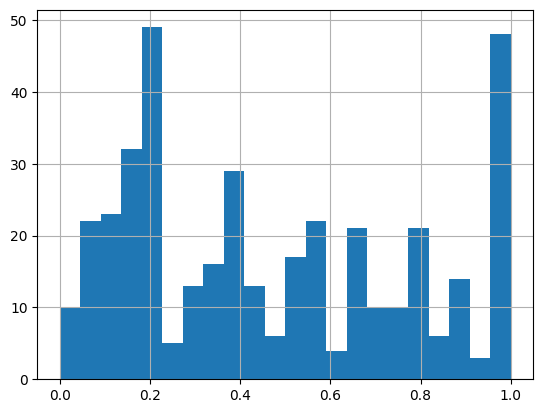

In [97]:
# 40 problems with no errors at all?
# 92 problems that always error.
labels_rates["error_rate"].hist(bins=len(scores_df))

In [98]:
exp_df["header"].str.split(" ").str[0].value_counts()

header
float              195
vec3                98
vec2                48
vec4                30
void                 7
mat3                 4
v33                  3
bound3               2
tilingVal3D          2
cast_ray_result      1
bool                 1
hexParams            1
ivec2                1
ivec3                1
Name: count, dtype: int64

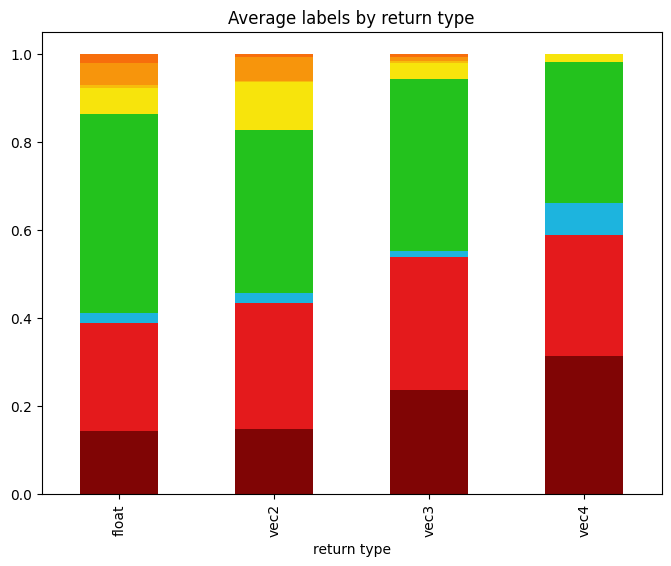

In [99]:
# error rate per datatype that appears 30 or more times.
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
labels_rates.iloc[:,:-2].groupby(exp_df["header"].str.split(" ").str[0]).mean().loc[["float", "vec2", "vec3", "vec4"]].reindex(columns=list(colors.keys())).plot(kind="bar", stacked=True, colormap=col_map, xlabel="return type", ax=ax, legend=False)
plt.title("Average labels by return type")
plt.savefig("../../Thesis/report/texs/charts/return_type.png", bbox_inches="tight")
plt.show()

In [100]:
# there is one problem that is exact match for all models!
# and one is c1 clone for all models...
# we can reduce the number/threshold to still have results here.
exp_df[(labels_rates["c0-clone"] >= .7) | (labels_rates["c1-clone"] >= 0.7)] #shared index is loveley!


,id,author,date,image_code,license,func_bytes,functions,comment,header,body,model_inp,function_frequency,gens
47,Xs3GRM,sagarpatel,2015-11-26 04:07:03,// CC0 1.0\n// @sagzorz\n \nconst bool isPseud...,cc0-1.0,"[5182, 5395, 5418, 5418, 5436]","[[1507, 1728, 1757, 1757, 2660], [2663, 2798, ...",// ~~~~~~~ signed distance function for plane\...,float sdPlane(vec3 p)\n{,\n return p.y;\n},// ~~~~~~~ signed distance function for plane\...,7,#ifdef _PLANE_\n return p.y;\n#else\n re...
257,sstfzM,mrange,2022-06-26 19:12:30,// License CC0 - Complex atanh - darkmode edit...,cc0-1.0,"[1766, 1879, 1906, 1906, 1958]","[[621, 621, 643, 643, 789], [1084, 1170, 1206,...",// Complex trig functions found at: Complex At...,"vec2 cmul(vec2 z, vec2 w) {","\n return vec2 (z.x*w.x-z.y*w.y, z.x*w.y+z.y*...",// Complex trig functions found at: Complex At...,1,"\n return vec2(z.x * w.x - z.y * w.y, z.x *..."


In [101]:
# lets look at the most difficult instances
for r in exp_df.loc[difficulty_order].tail(15).itertuples():
    print(f"https://shadertoy.com/view/{r.id} - {r.header!r}")

https://shadertoy.com/view/WdVyDW - 'float SegmentTracing(vec3 o, vec3 u, out bool h, out int s)\n{'
https://shadertoy.com/view/Wdd3zs - 'cast_ray_result cast_ray(vec3 ray_origin, vec3 ray_target) {'
https://shadertoy.com/view/4d33z4 - 'vec3 colorTheWorld( vec2 rayHitInfo , vec3 eyePosition , vec3 rayDirection ){'
https://shadertoy.com/view/fsXcRN - 'vec3 IntegrateScattering(vec3 rayStart, vec3 rayDir, float rayLength, vec3 lightDir, vec3 lightColor, out vec3 transmittance)\n{'
https://shadertoy.com/view/fddfRn - 'tilingVal3D rohmCell(vec3 uvw, vec3 offset, float gridRes) {'
https://shadertoy.com/view/DdlyRr - 'vec3 water(vec2 uv, vec3 cdir)\n{'
https://shadertoy.com/view/Xs3GRM - 'vec3 render_AA(vec2 fCoord,vec3 cPos,mat3 cMat)\n{'
https://shadertoy.com/view/7dycDV - 'hexParams hexTile(vec2 uv) {'
https://shadertoy.com/view/Xs3GRM - 'vec3 nearbyNormalsDiff(vec3 p, vec3 oN)\n{'
https://shadertoy.com/view/fddfRn - 'tilingVal3D rohmTile(vec3 uvw) {'
https://shadertoy.com/view/4d33z4 - 'v

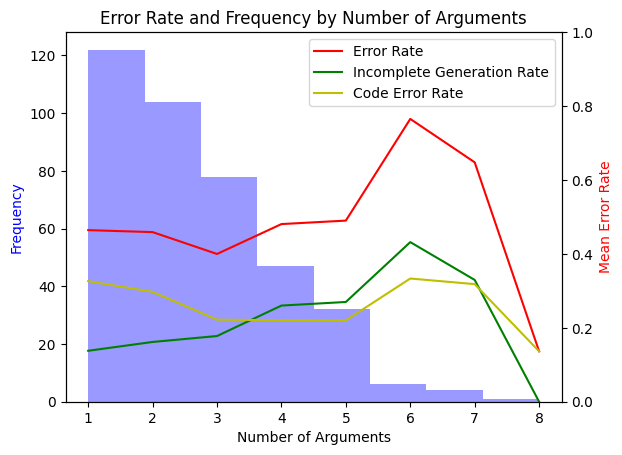

In [102]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the histogram on the primary y-axis
ax1.hist(exp_df["header"].str.count(",")+1, bins=8, alpha=0.4, color='b') #aling=left?
ax1.set_xlabel('Number of Arguments')
ax1.set_ylabel('Frequency', color='b')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(labels_rates["error_rate"].groupby(exp_df["header"].str.count(",")+1).mean(), color='r', label='Error Rate')
ax2.plot(labels_rates["incomplete_generation"].groupby(exp_df["header"].str.count(",")+1).mean(), color='g', label='Incomplete Generation Rate')
ax2.plot(labels_rates["code_error"].groupby(exp_df["header"].str.count(",")+1).mean(), color='y', label='Code Error Rate')
ax2.set_ylabel('Mean Error Rate', color='r')
ax2.set_ylim(0.0, 1.0) #ensure the scale is honest.

plt.title('Error Rate and Frequency by Number of Arguments')
plt.legend()
plt.show()

<Axes: xlabel='num args'>

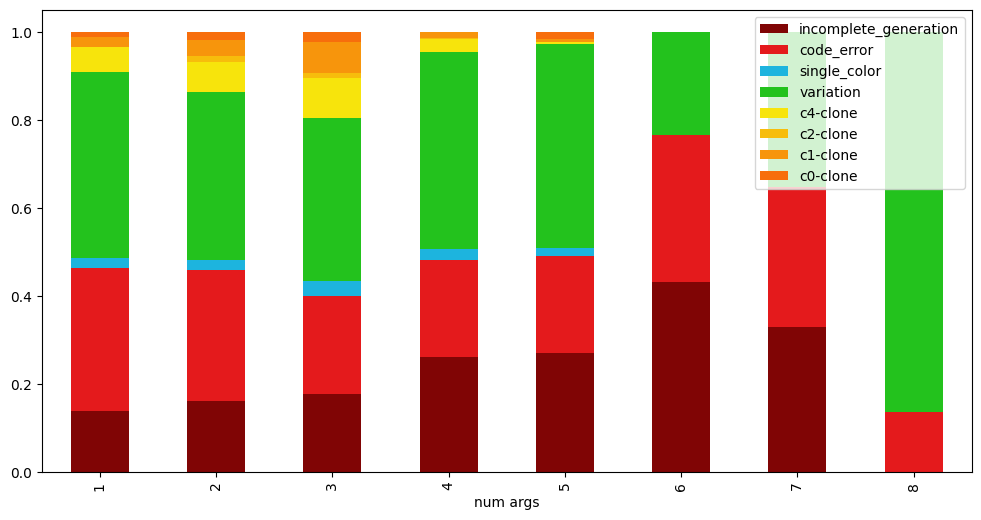

In [103]:
# print whole label stack per num_args?
# seems not very indicative and unreliable past the 5th col... not that useful actually.
labels_rates.iloc[:,:-2].groupby(exp_df["header"].str.count(",")+1).mean().reindex(columns=list(colors.keys())).plot(kind="bar", stacked=True, figsize=(12, 6), colormap=col_map, xlabel="num args")

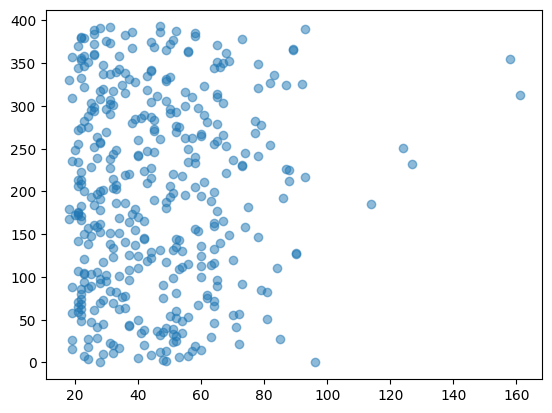

In [104]:
# error rate by length of model input/header/comment
# can be extended to all labels
# maybe we can get a trend line into the scatter plot somehow?

plt.scatter(x=exp_df["header"].str.len(), y=difficulty_order, alpha=0.5)

[[1.         0.43966384]
 [0.43966384 1.        ]]


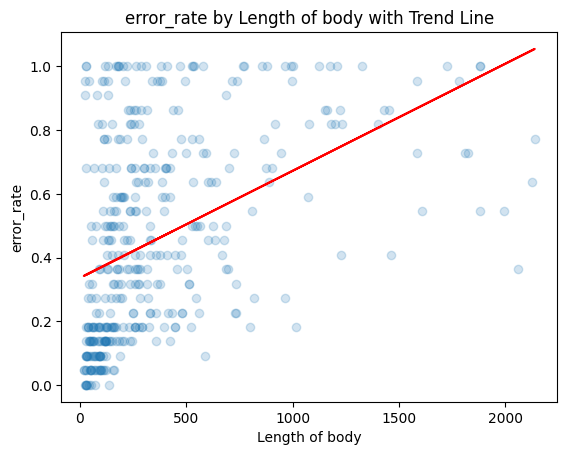

In [105]:
# so longer inputs cause generation failures?
# but code_error goes down (because it doesn't include the incomplete generatiosn anymore)
# TODO: since the rates are still like concrete steps... they don't mean much for an actual scatter plot.
# this is also shown by SWE Bench "larger changes are more likely to have errors?"

import matplotlib.pyplot as plt
import numpy as np

# Extract the x and y data
input_feature = "body" # "header" or "model_inp" or "comment"
label_feature = "error_rate" # "error_rate" or "incomplete_generation" or "code_error" etc
x = exp_df[input_feature].str.len()
y = labels_rates[label_feature]

print(np.corrcoef(x, y))
# Create the scatter plot
plt.scatter(x, y, alpha=0.2)

# Fit a linear trend line # TODO: is this even correct? what is the error?
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Plot the trend line
plt.plot(x, p(x), color='red')
# plt.xlim(0,x.quantile(0.99)+x.std()) #cutoff the outliers?

plt.xlabel(f'Length of {input_feature}')
plt.ylabel(label_feature)
plt.title(f'{label_feature} by Length of {input_feature} with Trend Line')
plt.show()

<Axes: >

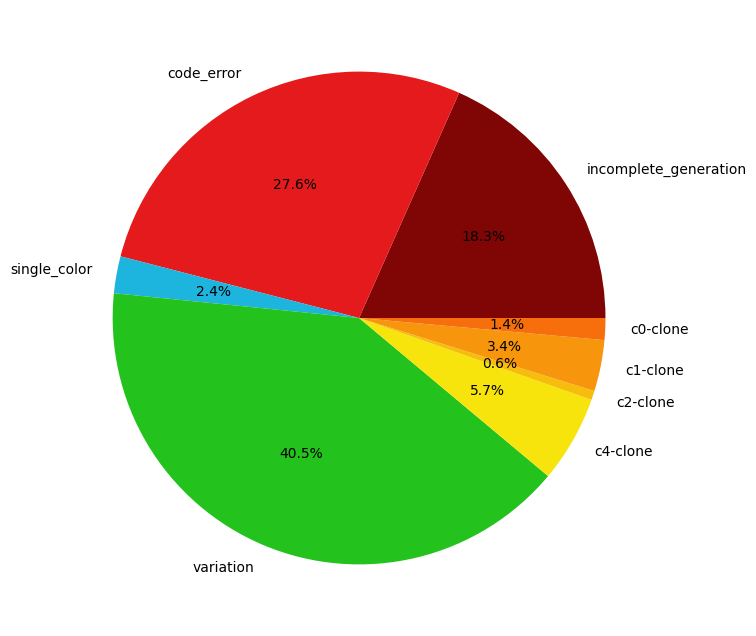

In [106]:
# the labels avaerged. (16 models right now)
scores_df.iloc[:,:-2].mean(numeric_only=True)[colors.keys()].plot.pie(cmap=col_map, autopct='%1.1f%%', figsize=(8, 8))

In [107]:
scores_df.iloc[:,-2:].mean()

error_rate    0.459737
clone_rate    0.110868
dtype: float64

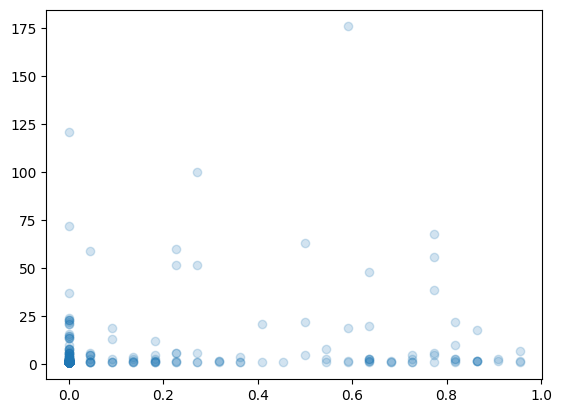

In [108]:
# do frequent functions cause mor exact copy? hard to tell be cause the data is noisy af
plt.scatter(labels_rates["clone_rate"], exp_df["function_frequency"], alpha=0.2)

<Axes: xlabel='Function Frequency'>

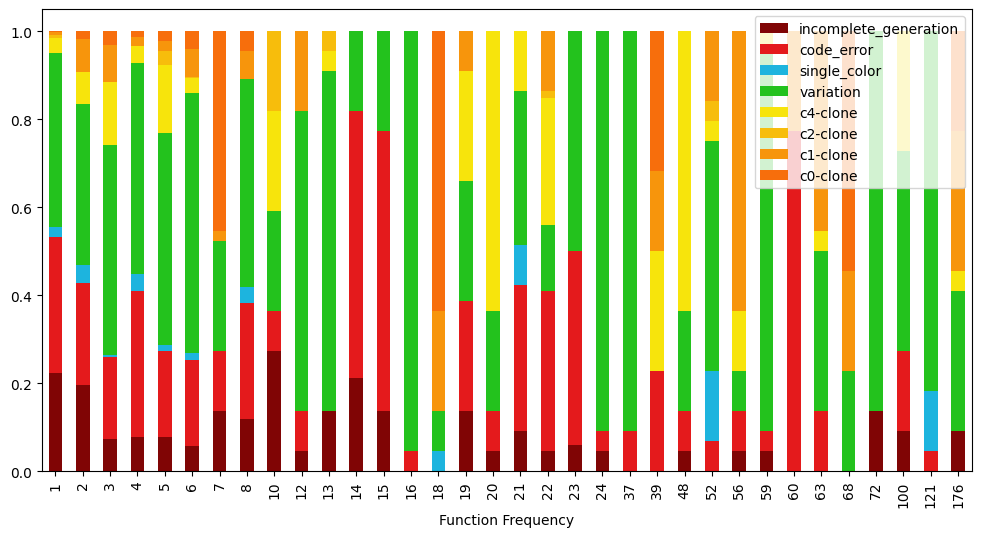

In [109]:
# this is each frequency on it's own...

# Group by 'function_frequency' and calculate the mean for each label
grouped_labels_rates = labels_rates.iloc[:, :-2].groupby(exp_df["function_frequency"]).mean()

# Plotting
grouped_labels_rates.reindex(columns=list(colors.keys())).plot(
	kind="bar", 
	stacked=True, 
	figsize=(12, 6), 
	colormap=col_map, 
	xlabel="Function Frequency"
)

<Axes: xlabel='Function Frequency'>

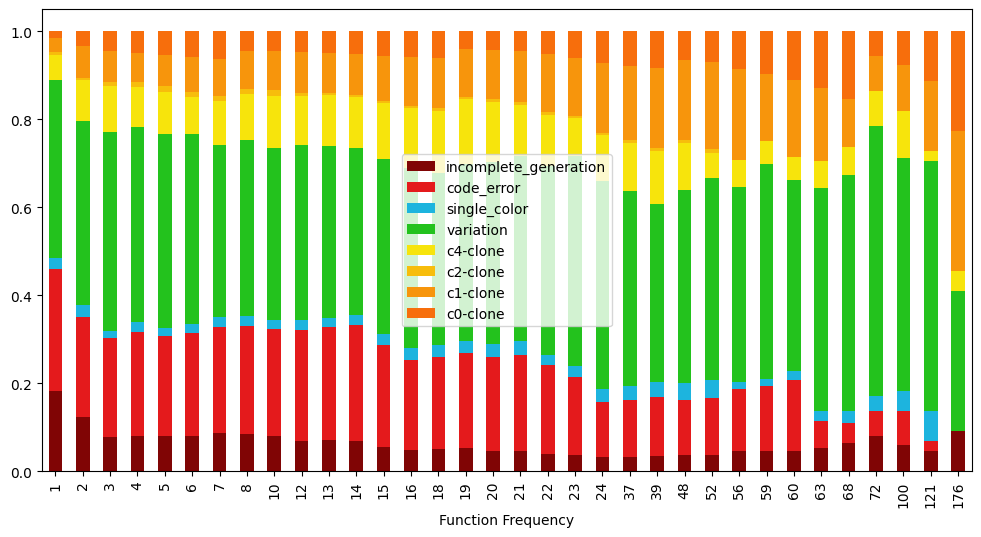

In [110]:
# here we add from the right. so it's accumulative from left to right (otherway around doesn't show much)
# basic idea is... the rare functions are (low frequency) the more likely the cause errors, but we ignore the outliers... also the x scale isn't linear.

geq_freq = pd.DataFrame()
for freq in exp_df["function_frequency"].unique():
    geq_freq[freq] = labels_rates[exp_df["function_frequency"] >= freq].mean()


geq_freq.T.sort_index().reindex(columns=list(colors.keys())).plot(
    kind="bar", 
    stacked=True, 
    figsize=(12, 6), 
    colormap=col_map, 
    xlabel="Function Frequency"
)

In [111]:
labels_df.shape

(394, 22)

<Axes: xlabel='Function Frequency'>

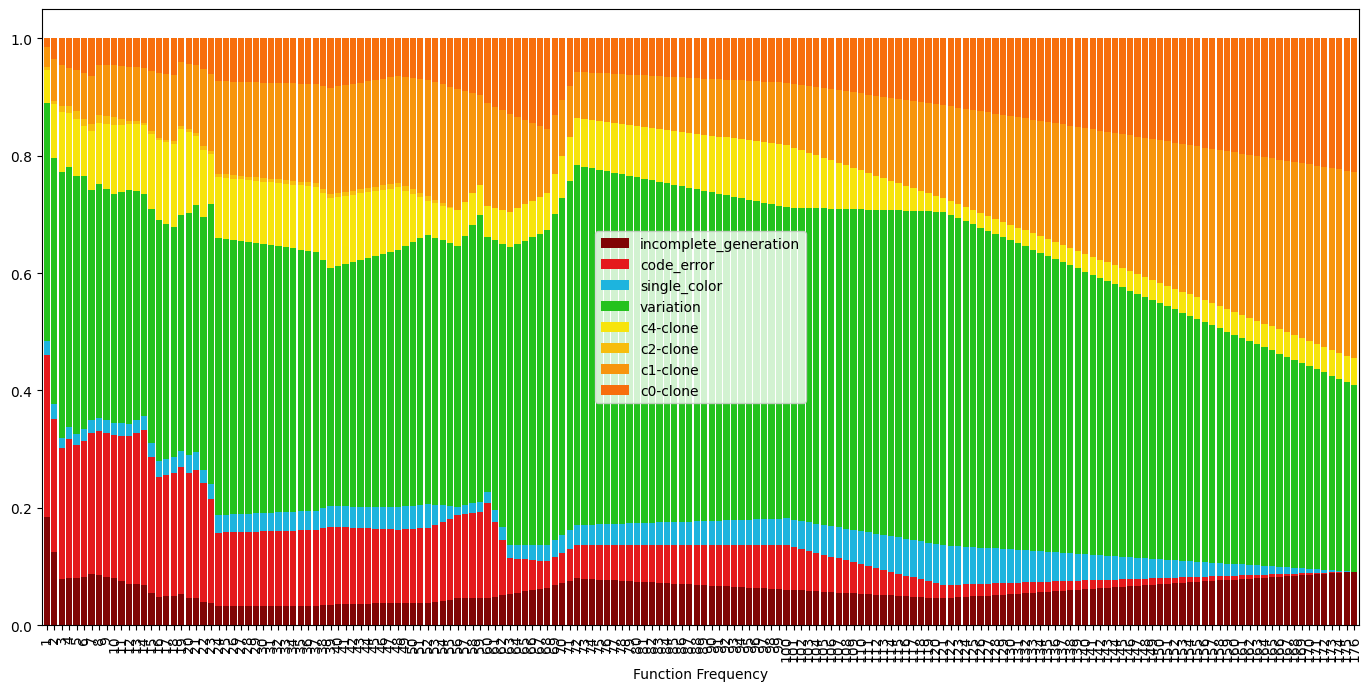

In [112]:
# now this is just fun and awful: by interpolating the values and having a linear x scale you can see a bit of a trend. although you miss how few data points there are per frequency, hence this isn't saying much...

geq_freq.T.reindex(range(1,geq_freq.T.index.max()+1)).interpolate(method='linear').reindex(columns=list(colors.keys())).plot(
    kind="bar", 
    stacked=True, 
    figsize=(17, 8), 
    colormap=col_map, 
    xlabel="Function Frequency",
    width=0.85
)

In [113]:
# investigate Starcoder2-15B n=12
n = 12
from annotate import PARSER
from tree_sitter import Language, Parser, Node
def _parse_function(code:str) -> list[Node]:
    """
    returns a list of functions as tree-sitter Nodes parsed from the code.
    #TODO: what about the has_error part?
    """
    tree = PARSER.parse(bytes(code, encoding="utf-8"))
    functions = []
    for child in tree.root_node.children:
        if child.type == "function_definition":
            functions.append(child)
    return functions


parsed_funcs = _parse_function(exp_df.iloc[n]["model_inp"] + exp_df.iloc[n]["gens"])
print(parsed_funcs[-1].text.decode(encoding="utf-8"))
# print(parsed_funcs)
# exp_df.iloc[n]

ModuleNotFoundError: No module named 'annotate'

In [48]:
combined = exp_df.iloc[n]["model_inp"] + exp_df.iloc[n]["gens"]
# print(combined)
detected_func = _parse_function(combined)[0]
for c in detected_func.children:
    if c.has_error:
        print(c)
        for sub_child in c.children:
            print(sub_child)
            print(sub_child.has_error)

(compound_statement (declaration type: (primitive_type) declarator: (init_declarator declarator: (identifier) value: (number_literal))) (declaration type: (primitive_type) declarator: (init_declarator declarator: (identifier) value: (number_literal))) (declaration type: (primitive_type) declarator: (init_declarator declarator: (identifier) value: (number_literal))) (declaration type: (primitive_type) declarator: (init_declarator declarator: (identifier) value: (number_literal))) (declaration type: (primitive_type) declarator: (init_declarator declarator: (identifier) value: (number_literal))) (declaration type: (primitive_type) declarator: (init_declarator declarator: (identifier) value: (number_literal))) (declaration type: (primitive_type) declarator: (init_declarator declarator: (identifier) value: (number_literal))) (declaration type: (primitive_type) declarator: (init_declarator declarator: (identifier) value: (number_literal))) (declaration type: (primitive_type) declarator: (ini

In [20]:
# print(exp_df.iloc[n]["image_code"])
exp_df.iloc[n]

id                                                               4dSXDd
author                                                       otaviogood
date                                                2014-11-27 22:26:38
image_code            /*--------------------------------------------...
license                                                         cc0-1.0
func_bytes                               [4341, 4412, 4444, 4534, 6672]
functions             [[695, 714, 737, 737, 810], [811, 811, 834, 83...
comment               // This is the big money function that makes t...
header                                float DistanceToObject(vec3 p)\n{
body                  \n    if (dot(p, rotDir) > 1.0) p *= rotMat;\n...
model_inp             // This is the big money function that makes t...
function_frequency                                                    1
gens                  \n\tfloat d = 1000000.0;\n\tfloat d2 = 1000000...
gen_truncated         \n\tfloat d = 1000000.0;\n\tfloat d2 = 100

In [75]:
# where does batched differ? 
# looks like input leaked or something. maybe batch inference is busted here.
exp_df[labels_df["CodeQwen1.5-7B-batched"] != labels_df["CodeQwen1.5-7B"]]["gen_truncated"]

2      \n    vec2 w = v - r;\n    return w.x * w.x + ...
3          \n    vec2 r2 = r.xy;\n    vec2 r3 = r.xyz...
4         \n    return v.x < 0.0? vec2(0.0, v.y) : v;\n}
7      #\n    vec4 p = p0 + t * (p1 - p0) + t * t * (...
8      #define PI 3.1415926535897932384626433832795\n...
                             ...                        
384    \n    vec2 uv = fragCoord - UV;\n    vec3 ray ...
386    \n    float r = rand() / (float)RAND_MAX;\n   ...
388    \n    vec3 u = p - vec3(0.5, 0.5, 0.5);\n    v...
392    \n    vec3 ray = pointEnd - pointStart;\n    v...
393    \n    vec3 a = vec3(0.0, 0.0, 0.0);\n    vec3 ...
Name: gen_truncated, Length: 190, dtype: object

In [35]:
import pandas as pd
model_infos = pd.read_csv("models.csv", index_col="model_id")
model_infos.head()

,org,size,family,FIM,languages
model_id,,,,,
deepseek-coder-1.3b-base,deepseek-ai,1.3,deepseek-coder,yes,87
deepseek-coder-5.7bmqa-base,deepseek-ai,5.7,deepseek-coder,yes,87
deepseek-coder-6.7b-base,deepseek-ai,6.7,deepseek-coder,yes,87
deepseek-coder-7b-base-v1.5,deepseek-ai,7.0,deepseek-coder1.5,no,87
CodeQwen1.5-7B,Qwen,7.0,CodeQwen,yes?,92


In [36]:
import matplotlib.pyplot as plt
merged_df = scores_df.merge(model_infos, left_index=True, right_index=True)
merged_df.head()

,incomplete_generation,c0-clone,c1-clone,c2-clone,c4-clone,code_error,single_color,variation,time,error_rate,clone_rate,org,size,family,FIM,languages
model_id,,,,,,,,,,,,,,,,
CodeLlama-13b-hf,0.101523,0.027919,0.038071,0.005076,0.073604,0.248731,0.022843,0.482234,2024-09-09 00:07:57.280036,0.350254,0.144670,meta-llama,13.0,CodeLlama,yes,0
CodeQwen1.5-7B,0.126904,0.022843,0.050761,0.020305,0.073604,0.223350,0.020305,0.461929,2024-08-22 01:24:24.615719,0.350254,0.167513,Qwen,7.0,CodeQwen,yes?,92
deepseek-coder-1.3b-base,0.142132,0.010152,0.032995,0.007614,0.053299,0.218274,0.032995,0.502538,2024-08-23 18:38:01.280256,0.360406,0.104061,deepseek-ai,1.3,deepseek-coder,yes,87
deepseek-coder-7b-base-v1.5,0.159898,0.030457,0.043147,0.005076,0.078680,0.200508,0.032995,0.449239,2024-09-09 00:30:26.568364,0.360406,0.157360,deepseek-ai,7.0,deepseek-coder1.5,no,87
deepseek-coder-5.7bmqa-base,0.114213,0.025381,0.048223,0.005076,0.076142,0.261421,0.015228,0.454315,2024-09-04 21:44:43.709038,0.375635,0.154822,deepseek-ai,5.7,deepseek-coder,yes,87


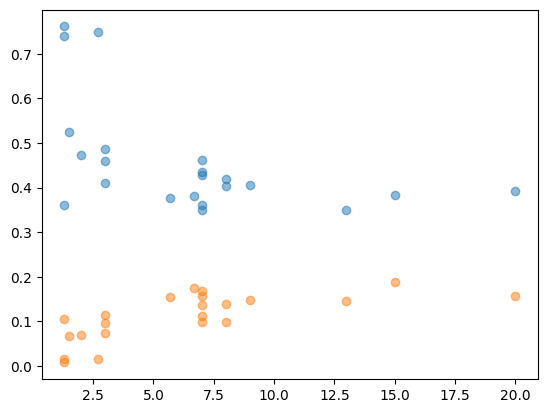

In [78]:
x_col = "size"
plt.scatter(merged_df[x_col], merged_df["error_rate"], alpha=0.5)
plt.scatter(merged_df[x_col], merged_df["clone_rate"], alpha=0.5)


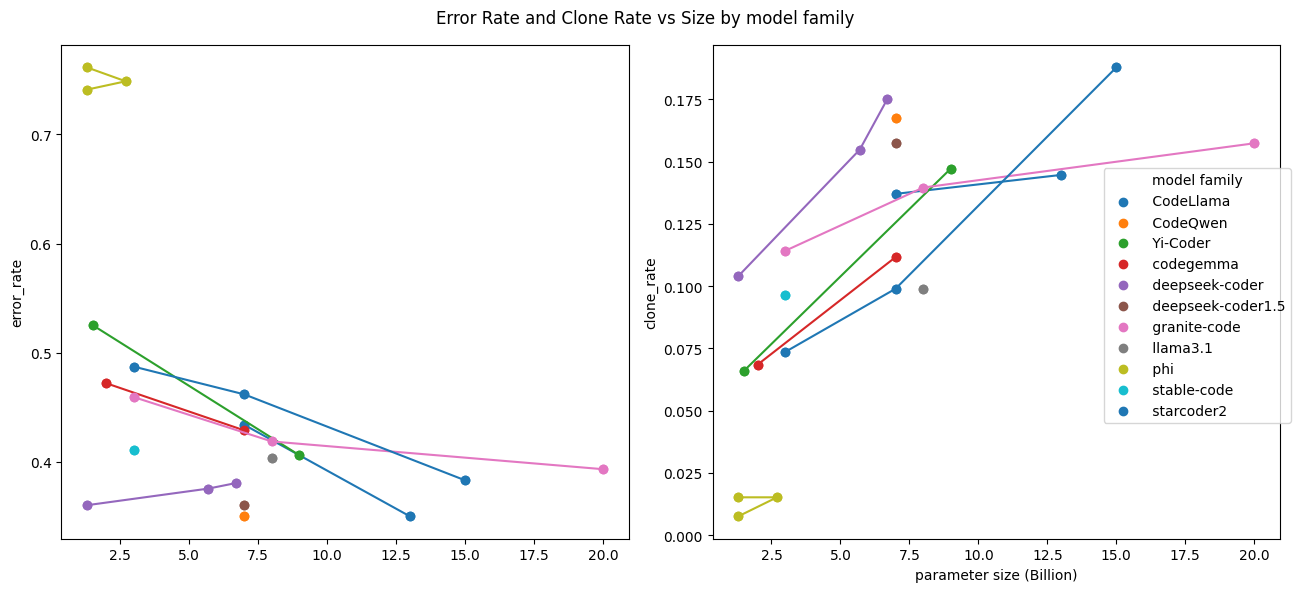

In [81]:
import matplotlib.pyplot as plt

# Count the number of entries per family
family_counts = merged_df['family'].value_counts()

# Filter out families with only one entry
family_counts = merged_df[merged_df['family'].isin(family_counts[family_counts > 0].index)] # set to 1 here to only see families with multiple models

# Group by the family class
grouped = family_counts.groupby('family')

# Define columns for the plots
y_cols = ["error_rate", "clone_rate"]
x_col = "size"

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 6))

# Plot each y_col in a separate subplot
for i, y_col in enumerate(y_cols):
    for name, group in grouped:
        axs[i].scatter(group[x_col], group[y_col], label=name)
        axs[i].plot(group[x_col], group[y_col], linestyle='-', marker='o')
    axs[i].set_ylabel(y_col)
    # axs[i].set_title(f'{y_col} vs Size by model family')

# Set common x label
axs[-1].set_xlabel('parameter size (Billion)')

# Create a single legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title='model family', loc='right')

# Save the figure
fig.suptitle('Error Rate and Clone Rate vs Size by model family')
plt.tight_layout()
plt.savefig("../../Thesis/report/texs/charts/error_clone_by_size_grouped.png", bbox_inches="tight")
plt.show()